# Мини задание 4

В этот раз будем знакомиться с AzureML и его возможностями.

**Постановка задачи**

В этом репозитории лежит архив с классическим датасетом MNIST. Ваша задача - обучить нейронную сеть распознавать числа на картинке, используя инструмент AzureML.  

Ссылка на датасет - https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/data/mnist/mnist_784.csv.gz

Полученную модель необходимо будет развернуть внутри облака, чтобы можно было сделать запрос по HTTP и получить предсказание.

**Как сдавать**

К данному заданию прилагается автоматическая система проверки. Она развернута по адресу http://autochecker.westus.cloudapp.azure.com:8080/ . Там есть небольшая формочка, в которую необходимо внести следующую информацию

* Имя и фамилию на русском
* Ссылку на вашу развернутую модель

После нажатия `Проверить!` система сделает несколько запросов к вашей модели и проверит, что она правда работает. 

Будет сделано несколько запросов с очень небольшим подмножеством наблюдений, собраны ответы и подсчитана `accuracy`. Необходимо набрать `accuracy` больше 0.5! 

Код, который будет отправлять запрос, выглядит примерно так

```
request_data = [X_test[i].tolist()]  # Здесь будет находится ровно одно наблюдение

r = requests.post(
    service_url, json={"method": "predict", "data": request_data}
)

prediction = r.json()["label"]  # Предсказание для этого конкретного наблюдения
```

Учитывайте это при проектировании своей модели, одна должна уметь обрабатывать именно такие запросы.

Если что, весь код сервиса нахотся вот тут - https://github.com/ADKosm/lsml-2021-autochecker . Можно посмотреть, как в точности будет проверяться ваша домашка. Если будут какие-то проблемы с работой - сразу пишите мне в ТГ, будем решать этот вопросик.

Системе потребуется около минуты на то, чтобы отправить все запросы, после чего она напишет вам информацию о том, как все прошло (а также пришлет вам персонализированную гифку!). Эту информацию необходимо будет скопировать в ноутбук с решением. 

Пример

```
Submit id: c9f37e31-63f4-47af-9d01-ac207928b609
Service url: http://2896051b-2ce5-403d-882b-65b3f6c4735a.westus.azurecontainer.io/score
Accuracy: 0.9838095238095238
```

Можно делать больше одной проверки - все попытки сохраняются у нас в табличке, но мы будем смотреть только на ту, которую вы укажите в ноутбуке (по идентификатору).

**Итого**, что должно быть в итоговом ноутбуке, который вы будете сдавать

* Сам код на Python, который с нуля разворачивает workspace, поднимает там мощности, обучает модель и разворачивает ее в облаке
* Информацию из автопроверяющей системы
* Скриншот с метриками `Loss` и `Accuracy` для вашего запуска. Должны быть видны два графика на скриншоте.

**Важно**. После того, как вы проверили свое решение в проверяющей системе, удаляйте AzureML к чертовой матери, чтобы он больше не жрал ваши деньги. 

**Важно**. Обучать распределенно **не требуется**. Однако, если вы запустите распределенное обучение в кластере через Horovod, то получите **+2 дополнительных балла**.

**Важно**. Бейзлайн очень простой и поэтмоу как-то особенно подбирать архитектуру сети и тюнить параметры не требуется. Однако, если вы запустите перебор гиперпараметров через hyperdrive, то получите **+2 дополнительных балла**.

In [1]:
!python -m pip install pip==20.1.1

You should consider upgrading via the '/Users/arinaruck/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
! pip3 install azureml-train-core azureml-core azureml-automl-runtime matplotlib
! az login

     |████████████████████████████████| 101 kB 2.7 MB/s ta 0:00:01


     |████████████████████████████████| 147 kB 12.6 MB/s eta 0:00:01
  Attempting uninstall: ruamel.yaml
    Found existing installation: ruamel.yaml 0.11.14
    Uninstalling ruamel.yaml-0.11.14:
      Successfully uninstalled ruamel.yaml-0.11.14
You should consider upgrading via the '/Users/arinaruck/anaconda3/bin/python -m pip install --upgrade pip' command.
The default web browser has been opened at https://login.microsoftonline.com/common/oauth2/authorize. Please continue the login in the web browser. If no web browser is available or if the web browser fails to open, use device code flow with `az login --use-device-code`.
You have logged in. Now let us find all the subscriptions to which you have access...
[
  {
    "cloudName": "AzureCloud",
    "homeTenantId": "fa34e92c-e581-439a-b6ae-b41b61270513",
    "id": "dfeaef04-2e5c-4480-8ebf-301863ed526a",
    "isDefault": true,
    "managedByTenants": [],
    "name": "Microsoft Azure Sponsorship 2",
    "state": "Disabled",
    "tenant

In [17]:
!pip install ruamel_yaml==0.15.35

     |████████████████████████████████| 260 kB 2.5 MB/s eta 0:00:01
  Created wheel for ruamel-yaml: filename=ruamel.yaml-0.15.35-cp36-cp36m-macosx_10_9_x86_64.whl size=209807 sha256=121f7c68a57daf4eba3e8ab8c51fba0383673981d6ab00692146f97511549455
  Stored in directory: /Users/arinaruck/Library/Caches/pip/wheels/68/3e/1e/db661642d56de6ad3c16e2274795127240cf79757cb720d8e3
Successfully built ruamel-yaml
  Attempting uninstall: ruamel-yaml
    Found existing installation: ruamel-yaml 0.15.87
ERROR: Cannot uninstall 'ruamel-yaml'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
You should consider upgrading via the '/Users/arinaruck/anaconda3/bin/python -m pip install --upgrade pip' command.


In [3]:
from azureml.core import Workspace

ws = Workspace.create(
    name = 'ml-workspace-1',
    subscription_id = '3750c13c-7871-4812-9fd5-94fb4ce86681',  # Укажите свою подписку
    resource_group = 'lsml-resource-group', # Укажите свою группу
    sku = 'enterprise',
    exist_ok = True
)
ws.get_details()

ws.write_config()

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Deploying KeyVault with name mlworkspkeyvault3a5576a1.
Deploying StorageAccount with name mlworkspstoragedebf14ddc.
Deploying AppInsights with name mlworkspinsightsc906a05c.
Deployed AppInsights with name mlworkspinsightsc906a05c. Took 6.27 seconds.
Deployed KeyVault with name mlworkspkeyvault3a5576a1. Took 24.74 seconds.
Deployed StorageAccount with name mlworkspstoragedebf14ddc. Took 30.53 seconds.
Deploying Workspace with name ml-workspace-1.
Deployed Workspace with name ml-workspace-1. Took 47.69 seconds.


In [4]:
! mkdir -p data
! curl -o- https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/data/mnist/mnist_784.csv.gz | gunzip > data/mnist_784.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.1M  100 14.1M    0     0  2218k      0  0:00:06  0:00:06 --:--:-- 2887k


In [5]:
!ls data

airbnb-300k.tsv  mnist_784.csv    sem2
mnist            mnist_784.csv.gz


In [6]:
import os
os.getcwd()

'/Users/arinaruck/Desktop/cs/lsml/lsml-2021-public'

In [7]:
local_files = [ 
    os.getcwd() + "/data/mnist_784.csv"
]

datastore = ws.get_default_datastore()
datastore.upload_files(files=local_files, target_path='mnist-data', show_progress=True)

Uploading an estimated of 1 files
Uploading /Users/arinaruck/Desktop/cs/lsml/lsml-2021-public/data/mnist_784.csv
Uploaded /Users/arinaruck/Desktop/cs/lsml/lsml-2021-public/data/mnist_784.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_33de05dff5944e1d992e8212e524ce05

In [8]:
#! wget https://packages.microsoft.com/config/ubuntu/20.04/packages-microsoft-prod.deb -O packages-microsoft-prod.deb
#! dpkg -i packages-microsoft-prod.deb

In [9]:
from azureml.core.dataset import Dataset

dataset = Dataset.File.from_files(path=(datastore, 'mnist-data'))
dataset = dataset.register(
    workspace=ws,
    name='mnist-data',
    description='mnist data'
)

In [10]:
! mkdir -p torch-mnist

In [11]:
%%writefile torch-mnist/train.py
from __future__ import print_function, division
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import argparse
import copy
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

from azureml.core.run import Run  # Специальный объект контекста. Он будет использоваться для связью к Azureml
run = Run.get_context()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,128)
        self.linear2 = nn.Linear(128,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return X


def load_data(data_dir, batch_size = 32):
    data_csv = pd.read_csv("{}/mnist_784.csv".format(data_dir))
    num_objects = len(data_csv)
    train_idx, test_idx = train_test_split(np.arange(num_objects), test_size=0.1)
    
    y_train = data_csv['class'].values[train_idx]
    X_train = data_csv.drop(['class'],axis=1).values[train_idx]

    y_test = data_csv['class'].values[test_idx]
    X_test = data_csv.drop(['class'],axis=1).values[test_idx]

    torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
    torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
    torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
    torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

    train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
    test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
    return train_loader, test_loader


def fit(model, train_loader, epoch_number=5, batch_size=32):
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.CrossEntropyLoss()
    model.train()
    
    for epoch in range(epoch_number):
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.float().to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            output = model(X_batch)
            loss = error(output, y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == y_batch).sum()
            
            if batch_idx % 200 == 0:
                loss = loss.data
                accuracy = float(correct*100) / float(batch_size*(batch_idx+1))
                run.log('Loss', float(loss))  # Вместо обычных print, используем функцию логгирования.
                run.log('Accuracy', float(accuracy))  # Эти данные будут собираться и отображаться в студии
                
                
def evaluate(model, test_loader, batch_size=32):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float().to(device)
        
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels.to(device)).sum()
    
    accuracy = float(correct) / (len(test_loader)*batch_size)
    run.log('Test accuracy', accuracy)  # Пишем итоговое качества


def main():
    # Скрипт будет "как-бы" запускаться через командную строку. Поэтому параметры запуска будем получать
    # из аргументов командной строки
    parser = argparse.ArgumentParser()  
    # В следующем параметре указываем директорию, где будут лежать данные для обучения
    # Про то, как они туда попадут - ниже
    parser.add_argument('--data_path', type=str, help='Path to the training data')
    # Директория, куда положить веса модели
    parser.add_argument('--output_dir', type=str, help='output directory')
    
    # Другие параметры модели. Можно добавлять произвольное количество любых параметров
    parser.add_argument('--num_epochs', type=int, default=20, help='number of epochs to train')
    parser.add_argument('--batch_size', type=int, default=32, help='number of examples in one batch')
    args = parser.parse_args()
    
    train_loader, test_loader = load_data(args.data_path, batch_size=args.batch_size)
    
    mlp = MLP()
    mlp.to(device)
    
    fit(mlp, train_loader, epoch_number=args.num_epochs, batch_size=args.batch_size)
    evaluate(mlp, test_loader)
    
    os.makedirs(args.output_dir, exist_ok=True)  # Веса сохраняем в указанную директорию
    torch.save(mlp.state_dict(), os.path.join(args.output_dir, 'model.json'))
    

if __name__ == "__main__":
    main()

Overwriting torch-mnist/train.py


In [17]:
%%writefile deps.yaml
channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-defaults
  - torch==1.6.0
  - torchvision==0.7.0
  - future==0.17.1
  - pillow
  - pandas
  - numpy
  - sklearn

Overwriting deps.yaml


In [14]:
from azureml.core import Environment

pytorch_env = Environment.from_conda_specification(name = 'pytorch-1.6-gpu', file_path = './deps.yaml')

pytorch_env.docker.enabled = True
pytorch_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [42]:
from azureml.core import Experiment

experiment_name = 'pytorch-mnist'
experiment = Experiment(ws, name=experiment_name)

In [43]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(
        vm_size='Standard_NC6s_v3', # Тип машины с GPU
        vm_priority='lowpriority',
        min_nodes=1, 
        max_nodes=3
    )

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    compute_target.wait_for_completion(show_output=True, timeout_in_minutes=20)

Creating a new compute target...
Creating.........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded....................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [44]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(
    source_directory='torch-mnist',
    script='train.py',
    arguments=[
        '--num_epochs', 10, 
        '--output_dir', './outputs', 
        '--data_path', dataset.as_named_input('input').as_mount(),
        '--batch_size', 32
    ],
    compute_target=compute_target,
    environment=pytorch_env
)

In [51]:
run = experiment.submit(src)
run.wait_for_completion(show_output = True)

RunId: pytorch-mnist_1616851500_ac5f54f0
Web View: https://ml.azure.com/runs/pytorch-mnist_1616851500_ac5f54f0?wsid=/subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourcegroups/lsml-resource-group/workspaces/ml-workspace-1&tid=fa34e92c-e581-439a-b6ae-b41b61270513

Streaming azureml-logs/55_azureml-execution-tvmps_5ae1d3491b627bf089d936a62d8cc39b0cebbf2461421ec2a1c6eca3bafe06b0_p.txt

2021-03-27T13:25:22Z Starting output-watcher...
2021-03-27T13:25:22Z IsDedicatedCompute == False, starting polling for Low-Pri Preemption
2021-03-27T13:25:22Z Executing 'Copy ACR Details file' on 10.0.0.5
2021-03-27T13:25:22Z Copy ACR Details file succeeded on 10.0.0.5. Output: 
>>>   
>>>   
Login Succeeded
Using default tag: latest
latest: Pulling from azureml/azureml_25e6cb78b6103af17d967d864cd0a9b0
Digest: sha256:9adecbcc2b5fb6ccb63d17ca8d8fc0d8bca4bb83ee4f2fac7fbc002abe80b1f6
Status: Image is up to date for viennaglobal.azurecr.io/azureml/azureml_25e6cb78b6103af17d967d864cd0a9b0:latest
viennaglo


Streaming azureml-logs/70_driver_log.txt

bash: /azureml-envs/azureml_30934d4fda6670ccf0f93f425522c2db/lib/libtinfo.so.5: no version information available (required by bash)
2021/03/27 13:25:36 Attempt 1 of http call to http://10.0.0.5:16384/sendlogstoartifacts/info
bash: /azureml-envs/azureml_30934d4fda6670ccf0f93f425522c2db/lib/libtinfo.so.5: no version information available (required by bash)
2021/03/27 13:25:36 Attempt 1 of http call to http://10.0.0.5:16384/sendlogstoartifacts/status
[2021-03-27T13:25:36.984926] Entering context manager injector.
[context_manager_injector.py] Command line Options: Namespace(inject=['ProjectPythonPath:context_managers.ProjectPythonPath', 'Dataset:context_managers.Datasets', 'RunHistory:context_managers.RunHistory', 'TrackUserError:context_managers.TrackUserError'], invocation=['train.py', '--num_epochs', '10', '--output_dir', './outputs', '--data_path', 'DatasetConsumptionConfig:input', '--batch_size', '32'])
Script type = None
Starting the daemon

{'runId': 'pytorch-mnist_1616851500_ac5f54f0',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2021-03-27T13:25:22.132423Z',
 'endTimeUtc': '2021-03-27T13:26:44.612571Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'da8a7910-f791-43a1-9859-9afe6e150c4e',
  'azureml.git.repository_uri': 'https://github.com/ADKosm/lsml-2021-public.git',
  'mlflow.source.git.repoURL': 'https://github.com/ADKosm/lsml-2021-public.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '79a69282e6850ae009e6db5403497e2459cb682a',
  'mlflow.source.git.commit': '79a69282e6850ae009e6db5403497e2459cb682a',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'b46ace5b-4a62-4fea-aa10-99fc66bdaa23'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input', 'mechanism': 'Mount'}}

In [52]:
model = run.register_model(model_name='mnist-torch-mlp', model_path='outputs')

In [53]:
%%writefile torch-mnist/score.py

import os
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import json

from azureml.core.model import Model


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,128)
        self.linear2 = nn.Linear(128,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return X

def init():
    global model
    
    model = MLP()
    
    model_root = Model.get_model_path('mnist-torch-mlp')  
    model_path = os.path.join(model_root, 'model.json')
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Загружаем веса
    model.eval()


def run(input_data):
    input_data = torch.from_numpy(np.array(json.loads(input_data)['data'])).type(torch.LongTensor).float()

    softmax = nn.Softmax(dim=1)
    out = model(input_data)
    pred_probs = softmax(out)
    index = torch.argmax(pred_probs[0]).item()
    
    return {'label': index}


Writing torch-mnist/score.py


In [54]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(entry_script="torch-mnist/score.py", environment=pytorch_env)

aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1, 
    memory_gb=1, 
    tags={'data': 'mnist', 'framework':'pytorch'},
    description='Classify handwritten digits'
)

service = Model.deploy(
    workspace=ws, 
    name='mnist-torch-inf',
    models=[model],
    inference_config=inference_config,
    deployment_config=aciconfig
)

service.wait_for_deployment(True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-03-27 16:28:19+03:00 Creating Container Registry if not exists.
2021-03-27 16:28:19+03:00 Registering the environment.
2021-03-27 16:28:19+03:00 Use the existing image.
2021-03-27 16:28:20+03:00 Generating deployment configuration.
2021-03-27 16:28:20+03:00 Submitting deployment to compute.
2021-03-27 16:28:25+03:00 Checking the status of deployment mnist-torch-inf..
2021-03-27 16:35:25+03:00 Checking the status of inference endpoint mnist-torch-inf.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [55]:
print(service.get_logs())

/bin/bash: /azureml-envs/azureml_30934d4fda6670ccf0f93f425522c2db/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_30934d4fda6670ccf0f93f425522c2db/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_30934d4fda6670ccf0f93f425522c2db/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_30934d4fda6670ccf0f93f425522c2db/lib/libtinfo.so.5: no version information available (required by /bin/bash)
2021-03-27T13:35:17,580898600+00:00 - gunicorn/run 
2021-03-27T13:35:17,581432400+00:00 - rsyslog/run 
2021-03-27T13:35:17,590056900+00:00 - iot-server/run 
bash: /azureml-envs/azureml_30934d4fda6670ccf0f93f425522c2db/lib/libtinfo.so.5: no version information available (required by bash)
2021-03-27T13:35:17,662253500+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
/bin/bash: /azureml

In [56]:
service.scoring_uri

'http://6a3de9c6-ea3a-4ed6-8d06-46657bafccf1.westus.azurecontainer.io/score'

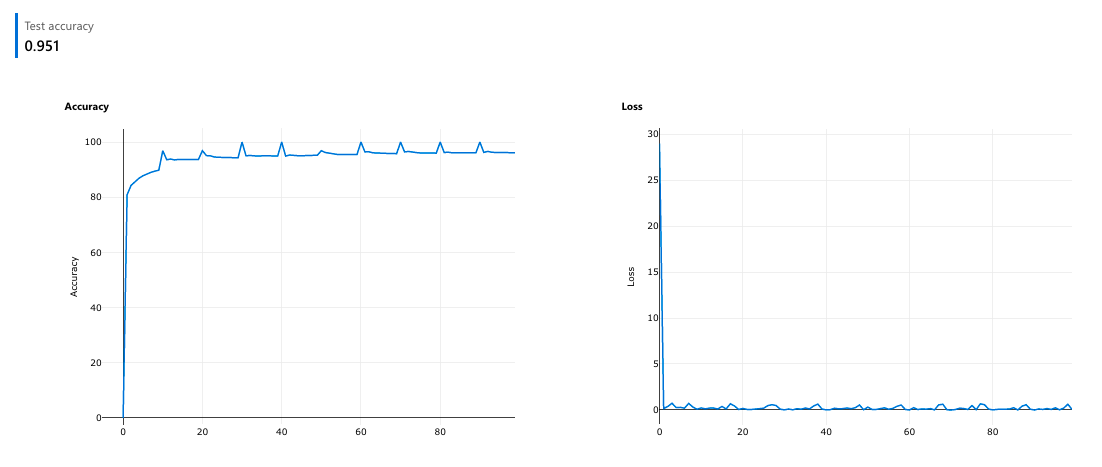

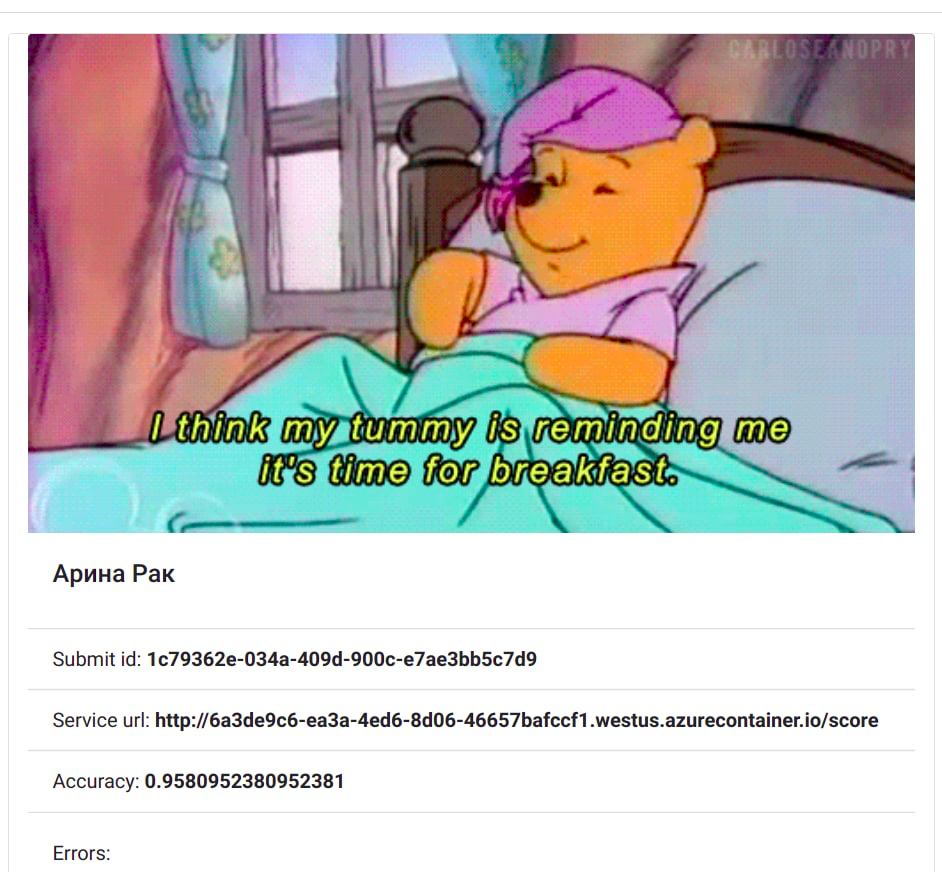

<img src="https://media3.giphy.com/media/N9OwoZgU2MONW/giphy.gif" width="750" align="center">

## Distributed

In [19]:
%%writefile dist-deps.yaml
channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-defaults
  - torch==1.6.0
  - torchvision==0.7.0
  - future==0.17.1
  - pillow
  - pandas
  - numpy
  - horovod==0.19.1

Overwriting dist-deps.yaml


In [20]:
from azureml.core import Environment

dist_pytorch_env = Environment.from_conda_specification(name = 'dist-pytorch-1.6-gpu', file_path = './dist-deps.yaml')

dist_pytorch_env.docker.enabled = True
dist_pytorch_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [22]:
!mkdir dist-torch

In [23]:
%%writefile dist-torch/train.py

from __future__ import print_function, division
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import argparse
import copy
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import horovod.torch as hvd

from sklearn.model_selection import train_test_split

from azureml.core.run import Run
run = Run.get_context()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hvd.init() 

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,128)
        self.linear2 = nn.Linear(128,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return X


def load_data(data_dir, batch_size = 32):
    data_csv = pd.read_csv("{}/mnist_784.csv".format(data_dir))
    num_objects = len(data_csv)
    train_idx, test_idx = train_test_split(np.arange(num_objects), test_size=0.1)
    
    y_train = data_csv['class'].values[train_idx]
    X_train = data_csv.drop(['class'],axis=1).values[train_idx]

    y_test = data_csv['class'].values[test_idx]
    X_test = data_csv.drop(['class'],axis=1).values[test_idx]

    torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
    torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
    torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
    torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

    train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
    test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

    
    # Данные дополнительно нужно опернуть в DistributedSampler, чтобы каждый воркер понимал, какую часть данных он обрабатывает
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train, 
        num_replicas=hvd.size(), # hvd.size возвращает общее количесто воркеров
        rank=hvd.rank()  # hvd.rank возвращает номер текущего воркера
    )
    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test,
        num_replicas=hvd.size(),
        rank=hvd.rank()
    )
    
    train_loader = torch.utils.data.DataLoader(
        train, 
        batch_size = batch_size, 
        sampler=train_sampler, 
        shuffle = False
    )
    test_loader = torch.utils.data.DataLoader(
        test, 
        batch_size = batch_size, 
        sampler=test_sampler, 
        shuffle = False
    )
    
    return train_loader, train_sampler, test_loader


def fit(model, train_loader, train_sampler,  batch_size=32, epoch_number=10, learning_rate=0.0001):
    hvd.broadcast_parameters(model.state_dict(), root_rank=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    run.log('learning_rate', np.float(learning_rate))
    optimizer = hvd.DistributedOptimizer(  
        optimizer,
        named_parameters=model.named_parameters()
    )
    
    error = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epoch_number):
        train_sampler.set_epoch(epoch)
        correct = 0
        
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float().to(device)
            var_y_batch = Variable(y_batch).to(device)
            
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            
            if batch_idx % 200 == 0:
                loss = loss.data
                accuracy = float(correct*100) / float(batch_size*(batch_idx+1))
                run.log('Loss', float(loss))
                run.log('Accuracy', float(accuracy))
                
                
def evaluate(model, test_loader, batch_size=32):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float().to(device)
        
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels.to(device)).sum()

    accuracy = float(correct) / (len(test_loader)*batch_size)
    
    accuracy_tensor = torch.tensor(accuracy)

    avg_tensor = hvd.allreduce(accuracy_tensor, name='avg_accuracy')
    result = avg_tensor.item()
    
    if hvd.rank() == 0: 
        run.log('test_accuracy', result)
        
    


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_path', type=str, help='Path to the training data')
    parser.add_argument('--output_dir', type=str, help='output directory')
    parser.add_argument('--batch_size', type=int, default=32, help='number of examples in one batch')
    parser.add_argument('--momentum', type=float, default=0.5, help='SGD momentum (default: 0.5)')
    parser.add_argument('--num_epochs', type=int, default=10, help='number of epochs to train')
    # Этот параметр будет перебирать
    parser.add_argument('--learning_rate', type=float, default=0.3, help='learning rate')
    
    args = parser.parse_args()
    
    train_loader, train_sampler, test_loader = load_data(args.data_path, batch_size=args.batch_size)
    
    mlp = MLP()
    mlp.to(device)
    
    fit(mlp, train_loader, train_sampler, batch_size=args.batch_size, 
        epoch_number=args.num_epochs, learning_rate=args.learning_rate)
    evaluate(mlp, test_loader)
    
    # Полученную модель будем сохранять только с одного воркера, а не со всех сразу
    if hvd.rank() == 0:
        os.makedirs(args.output_dir, exist_ok=True)
        torch.save(mlp.state_dict(), os.path.join(args.output_dir, 'model.json'))
    

if __name__ == "__main__":
    main()

Writing dist-torch/train.py


In [26]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(
        vm_size='Standard_NC6s_v3', # Тип машины с GPU
        vm_priority='lowpriority',
        min_nodes=1, 
        max_nodes=3
    )

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    compute_target.wait_for_completion(show_output=True, timeout_in_minutes=20)

Creating a new compute target...
Creating...
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded...................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [31]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import MpiConfiguration

src = ScriptRunConfig(
    source_directory='dist-torch',
    script='train.py',
    arguments=[
        '--output_dir', './outputs', 
        '--data_path', dataset.as_named_input('input').as_mount(),
        '--batch_size', 32
    ],
    compute_target=compute_target,
    environment=dist_pytorch_env,
    distributed_job_config=MpiConfiguration(node_count=3), # Указываем, что хотим 3 воркера для распределнного обучения
)

In [32]:
run = experiment.submit(src)
run.wait_for_completion(show_output = True)

RunId: pytorch-mnist-dist_1616964450_d6619f7d
Web View: https://ml.azure.com/runs/pytorch-mnist-dist_1616964450_d6619f7d?wsid=/subscriptions/3750c13c-7871-4812-9fd5-94fb4ce86681/resourcegroups/lsml-resource-group/workspaces/ml-workspace-1&tid=fa34e92c-e581-439a-b6ae-b41b61270513

Streaming azureml-logs/65_job_prep-tvmps_1ed1d1b650323d3f8752eb19e85edecd839679be54d2d8432c88021b804903c0_p.txt

[2021-03-28T20:51:58.941968] Entering job preparation.
[2021-03-28T20:51:59.458245] Starting job preparation.
[2021-03-28T20:51:59.458304] Extracting the control code.
[2021-03-28T20:51:59.465780] Finished fetching and extracting the control code.
[2021-03-28T20:51:59.465808] Not a master node. Skipping rest of the context managers.
[2021-03-28T20:51:59.465821] Entering Data Context Managers in Sidecar
[2021-03-28T20:51:59.466299] Running Sidecar prep cmd...
[2021-03-28T20:51:59.514054] INFO azureml.sidecar.sidecar: Received task: enter_contexts. Running on Linux at /mnt/hostfs/mnt/batch/tasks/share

ActivityFailedException: ActivityFailedException:
	Message: Activity Failed:
{
    "error": {
        "code": "UserError",
        "message": "AzureMLCompute job failed.\nJobFailed: Submitted script failed with a non-zero exit code; see the driver log file for details.\n\tReason: Job failed with non-zero exit Code",
        "messageFormat": "{Message}",
        "messageParameters": {
            "Message": "AzureMLCompute job failed.\nJobFailed: Submitted script failed with a non-zero exit code; see the driver log file for details.\n\tReason: Job failed with non-zero exit Code"
        },
        "details": [],
        "innerError": {
            "code": "BadArgument",
            "innerError": {
                "code": "AmlComputeBadRequest"
            }
        }
    },
    "correlation": {
        "operation": null,
        "request": "f0d44db76347c720"
    },
    "environment": "westus",
    "location": "westus",
    "time": "2021-03-28T20:54:28.244694Z",
    "componentName": "execution-worker"
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Activity Failed:\n{\n    \"error\": {\n        \"code\": \"UserError\",\n        \"message\": \"AzureMLCompute job failed.\\nJobFailed: Submitted script failed with a non-zero exit code; see the driver log file for details.\\n\\tReason: Job failed with non-zero exit Code\",\n        \"messageFormat\": \"{Message}\",\n        \"messageParameters\": {\n            \"Message\": \"AzureMLCompute job failed.\\nJobFailed: Submitted script failed with a non-zero exit code; see the driver log file for details.\\n\\tReason: Job failed with non-zero exit Code\"\n        },\n        \"details\": [],\n        \"innerError\": {\n            \"code\": \"BadArgument\",\n            \"innerError\": {\n                \"code\": \"AmlComputeBadRequest\"\n            }\n        }\n    },\n    \"correlation\": {\n        \"operation\": null,\n        \"request\": \"f0d44db76347c720\"\n    },\n    \"environment\": \"westus\",\n    \"location\": \"westus\",\n    \"time\": \"2021-03-28T20:54:28.244694Z\",\n    \"componentName\": \"execution-worker\"\n}"
    }
}

In [ ]:
model = run.register_model(model_name='dist-mnist-torch-mlp', model_path='outputs')

In [ ]:
%%writefile dist-torch-mnist/score.py

import os
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import json

from azureml.core.model import Model


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,128)
        self.linear2 = nn.Linear(128,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return X

def init():
    global model
    
    model = MLP()
    
    model_root = Model.get_model_path('dist-mnist-torch-mlp')  
    model_path = os.path.join(model_root, 'model.json')
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Загружаем веса
    model.eval()


def run(input_data):
    input_data = torch.from_numpy(np.array(json.loads(input_data)['data'])).type(torch.LongTensor).float()

    softmax = nn.Softmax(dim=1)
    out = model(input_data)
    pred_probs = softmax(out)
    index = torch.argmax(pred_probs[0]).item()
    
    return {'label': index}


In [ ]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(entry_script="dist-torch-mnist/score.py", environment=pytorch_env)

aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1, 
    memory_gb=1, 
    tags={'data': 'mnist', 'framework':'pytorch'},
    description='Classify handwritten digits'
)

service = Model.deploy(
    workspace=ws, 
    name='mnist-torch-inf',
    models=[model],
    inference_config=inference_config,
    deployment_config=aciconfig
)

service.wait_for_deployment(True)
print(service.state)

In [ ]:
service.scoring_uri

In [ ]:
ws.delete(delete_dependent_resources=True, no_wait=False)